In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('S&P500.csv', sep=";", index_col="Date")
df = df[df.columns[1:27]]
df = df.replace('N', np.NaN)
df = df.dropna()

In [4]:
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(len(df.columns))]
for i in range(len(df.columns)):
    df[df.columns[i]] = scalers[i].fit_transform(df[df.columns[i]].values.reshape(-1,1))
data_raw = df.values
for i in range(4):
    data_raw[:, i] = np.concatenate((np.diff(data_raw[:, i]), np.zeros(1)))



In [5]:
data = []
window_size = 70
train_ratio = 0.8


for i in range(len(data_raw) - window_size):
    data.append(data_raw[i : i + window_size])

data = np.array(data)
print(data.shape)
data = data.reshape((data.shape[0], data.shape[1], -1))
train_size = int(train_ratio * data.shape[0])
x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor)
y_train = torch.from_numpy(data[:train_size, -1, 1]).type(torch.Tensor).reshape(-1, 1)

x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor)
y_test = torch.from_numpy(data[train_size:, -1, 1]).type(torch.Tensor).reshape(-1, 1)

(1501, 70, 26)


In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model = LSTM(input_dim=26, hidden_dim=40, num_layers=4, output_dim=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
numEpochs = 80
history = np.zeros(numEpochs)
test_loss = []
for t in range(numEpochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    history[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t != 0:
        print("Epoch", t)
        print("Train MSE:", history[t])
        y_test_pred = model(x_test)
        loss = loss_fn(y_test_pred, y_test)
        test_loss.append(loss.item())
        print("Test MSE:", loss.item())
        print()
    




Epoch 10
Train MSE: 0.0006474930560216308
Test MSE: 0.0013335481053218246

Epoch 20
Train MSE: 0.0006242213421501219
Test MSE: 0.0012633061269298196

Epoch 30
Train MSE: 0.000596826896071434
Test MSE: 0.0012710216687992215

Epoch 40
Train MSE: 0.0005912449560128152
Test MSE: 0.0012826018501073122

Epoch 50
Train MSE: 0.0005896753864362836
Test MSE: 0.001282442593947053

Epoch 60
Train MSE: 0.000584181398153305
Test MSE: 0.001292200991883874

Epoch 70
Train MSE: 0.0005771545111201704
Test MSE: 0.0013863337226212025



In [8]:
#Getting todays Relevant tweets
!git clone --depth=1 https://github.com/adamlesniak/twint.git -q
!cd /content/twint && pip3 install . -r requirements.txt -q
!pip install vadersentiment -q

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 1.3 MB 3.9 MB/s 
     |████████████████████████████████| 263 kB 48.5 MB/s 
     |████████████████████████████████| 372 kB 58.8 MB/s 
     |████████████████████████████████| 271 kB 63.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 291 kB 48.9 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 138 kB 53.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [9]:
#Imports
import twint
import torch
import time
import datetime
import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

import nest_asyncio
nest_asyncio.apply()
#tweeter scraper

#change delta days to go back more days
def scrapetweets(end_time = datetime.datetime.now(), delta_days = 1, delta = 100, query="stock OR Nasdaq"):
  #setting up start and end times
  end_time = end_time-datetime.timedelta(days=delta_days)
  #till now 100 seconds ago
  start_time = end_time-datetime.timedelta(seconds=delta)
  #setting up the configuration for twint
  c = twint.Config()
  c.Lang = "en"
  c.Store_csv = True
  c.Search = query
  c.Since = start_time.strftime("%Y-%m-%d %H:%M:%S")
  c.Until = end_time.strftime("%Y-%m-%d %H:%M:%S")
  c.Hide_output = True
  #setting up where to put output
  filepath = str(delta_days) + "DaysAgoTweets"+ ".csv"
  c.Output = filepath
  #getting the tweets
  twint.run.Search(c)
  #save them in new by reading the file
  new = pd.read_csv(filepath)
  return new


#function to get sentiment
def get_sentiment(df):
  #getting the positive ones  applying the analyzer on the tweet and getting the three values
  df["pos"] = df.apply(lambda row: analyzer.polarity_scores(row["tweet"])["pos"], axis=1)
  df["compound"] = df.apply(lambda row: analyzer.polarity_scores(row["tweet"])["compound"], axis=1)
  df["neg"] = df.apply(lambda row: analyzer.polarity_scores(row["tweet"])["neg"], axis=1)
  sentval = df["compound"].mean()
  # if we need df["pos"].mean(), df["compound"].mean(),df["neg"].mean()
  print(df["pos"].mean())
  print(df["compound"].mean())
  print(df["neg"].mean())
  return sentval

In [ ]:
sentiment = get_sentiment(scrapetweets(delta_days = 1))
print("The Sentiment Score for today was", sentiment)


sentiment_array = np.zeros((len(y_test), 1))
temp_sentiment = 0
prev = 0
for i in range(len(y_test)):
  try:
    temp_sentiment = get_sentiment(scrapetweets(delta_days = i))
    prev = temp_sentiment
  except:
    temp_sentiment = prev
  print("sentiment for {} days ago is {}".format(i, temp_sentiment))
  sentiment_array[i] = temp_sentiment
  print()
  print("___________", i, "___________")
  print()

print(sentiment_array)


"""
[[ 0.17759741  0.19451606  0.12573744  0.1700756   0.08295123  0.08951322
   0.13697236  0.17972125  0.18176725  0.02644444  0.03502614  0.03434932
   0.11824605  0.18367719  0.26577333  0.225       0.07646341  0.1923
   0.17912451  0.08523191  0.08523191  0.14162188 -0.0093931   0.10428684
   0.09652222  0.08832471  0.14586131  0.01854333  0.2825125   0.07764304
   0.17005507  0.19161176  0.10844673  0.27123684  0.16746     0.34069375
   0.04685484 -0.00790833  0.284385    0.09744444  0.10805224  0.12021818
   0.17960303  0.08705789  0.06311233  0.05633036  0.08751827  0.11280185
   0.27532128  0.16349808  0.10619677  0.122955   -0.03525294  0.13982424
   0.16857143  0.10666077  0.31903929  0.0493292   0.1638      0.0538675
   0.16350182  0.16350182  0.18795517  0.160605    0.01605412  0.17245161
   0.14225963  0.06908649  0.07331571  0.16705652  0.01433214  0.2576098
   0.19493523  0.16904167  0.16904167 -0.00087105  0.2206875   0.20577315
  -0.03092941  0.18183203 -0.10955     0.0962875   0.22218235  0.22218235
   0.065035    0.12834     0.24746923  0.0792775   0.09926852  0.09926852
   0.11864595  0.1115     -0.00446    -0.00446    -0.00446     0.21456667
   0.16894808  0.19083784  0.06679741  0.14950833  0.07052391  0.24051875
   0.27438     0.27438     0.10301299  0.21622632  0.28670625  0.05373269
   0.13525111  0.17723816  0.17723816  0.17723816  0.07455     0.2079075
   0.2079075   0.11670571  0.16947333  0.17583108  0.17583108  0.27152105
   0.11929091  0.11929091  0.21194035  0.13071667  0.18078421  0.18078421
   0.10085949  0.10085949  0.07831176  0.12776964  0.01136364 -0.00645
   0.15392778  0.131004    0.19676154  0.102395    0.24360638  0.16617037
   0.27300238  0.16756512  0.22154045  0.245195    0.18962727  0.14980526
   0.15752941  0.30260556  0.12268974  0.14151026  0.14151026  0.13514118
   0.21262222  0.21262222  0.13356167  0.052065    0.20835246  0.20835246
   0.24093529  0.24093529  0.24093529  0.24704138  0.1103      0.16938
   0.11560725  0.10959394  0.08685612  0.15836875  0.12912368  0.12912368
   0.20424359  0.00129143  0.17109231  0.15287059  0.13552857  0.00373429
   0.00373429 -0.01808     0.12241373  0.25394026  0.09538202  0.11393333
   0.13909714  0.13909714  0.10964035  0.08138727  0.13410233  0.18423784
   0.18372105  0.17521455  0.15679444  0.08314133  0.13482857  0.039225
   0.14501875  0.10489364  0.19205294  0.19205294  0.19994     0.081735
   0.081735   -0.03504211  0.10266429  0.22012703  0.16748701  0.0851
   0.21882813  0.21882813  0.11436852  0.25826667  0.25826667  0.13303049
   0.16817442  0.20457222  0.20457222  0.11474722  0.11377368  0.210215
   0.13089717  0.13089717  0.07237609  0.1745413   0.22412941  0.22412941
   0.22412941  0.22285     0.18769419  0.196045    0.15411786  0.18491071
   0.15969412  0.094       0.10057885  0.10057885  0.24176071  0.240375
   0.07846316  0.06871667  0.09535556  0.09535556  0.14525263 -0.02420645
   0.24687941  0.23864     0.10251566  0.10931212  0.14477368  0.145285
   0.18720357  0.18720357  0.18720357  0.18720357  0.18720357  0.27137778
   0.13242118 -0.02725714  0.34340556  0.03334583  0.03334583  0.03334583
   0.03334583  0.03334583  0.07621667  0.134502    0.2312     -0.002035
  -0.002035   -0.002035    0.27143     0.27143     0.055675    0.23291096
   0.0647      0.0647      0.0647      0.0647      0.15247568  0.15344848
   0.24824667  0.24824667  0.03307368  0.15994167  0.10963906  0.10963906
   0.09879565  0.09879565  0.21789394  0.16868977  0.107485    0.05929189
   0.09376939  0.19283148  0.19283148  0.03860263  0.13039464  0.13039464
   0.0897618   0.1481775   0.189605    0.11234767  0.08649     0.1346475
   0.107765  ]]
sentiment array shape (301, 1)
"""


In [12]:
print(sentiment_array)

[[ 2.64447458e-01]
 [ 2.20381395e-01]
 [ 2.92540000e-01]
 [ 1.72198387e-01]
 [ 1.86106977e-01]
 [ 1.70824000e-01]
 [ 9.77000000e-02]
 [ 2.48930882e-01]
 [ 6.09428571e-02]
 [ 6.09428571e-02]
 [ 6.09428571e-02]
 [ 6.09428571e-02]
 [ 2.14247500e-01]
 [ 1.15935294e-01]
 [ 1.15935294e-01]
 [ 1.15935294e-01]
 [ 9.93894737e-02]
 [ 9.93894737e-02]
 [ 9.93894737e-02]
 [ 9.93894737e-02]
 [ 5.87222222e-02]
 [ 5.87222222e-02]
 [ 5.87222222e-02]
 [ 1.94500000e-01]
 [ 1.26465000e-01]
 [ 1.26465000e-01]
 [ 1.44341667e-01]
 [ 1.44341667e-01]
 [ 1.44341667e-01]
 [ 1.44341667e-01]
 [ 7.89000000e-02]
 [ 1.12955000e-01]
 [ 1.12955000e-01]
 [ 1.22045000e-01]
 [ 4.50888889e-02]
 [ 4.47071429e-02]
 [ 1.82680000e-01]
 [ 1.82680000e-01]
 [ 2.88679487e-01]
 [ 2.88679487e-01]
 [ 4.95723404e-02]
 [ 2.99735000e-01]
 [ 6.54950000e-02]
 [ 6.54950000e-02]
 [ 2.27078947e-01]
 [ 2.27078947e-01]
 [ 1.99520000e-01]
 [ 1.99520000e-01]
 [ 1.99520000e-01]
 [ 3.02955000e-01]
 [ 3.02955000e-01]
 [ 3.02955000e-01]
 [ 6.9600000

In [13]:
print(sentiment_array.T)
print("sentiment array shape", sentiment_array.shape)

[[ 2.64447458e-01  2.20381395e-01  2.92540000e-01  1.72198387e-01
   1.86106977e-01  1.70824000e-01  9.77000000e-02  2.48930882e-01
   6.09428571e-02  6.09428571e-02  6.09428571e-02  6.09428571e-02
   2.14247500e-01  1.15935294e-01  1.15935294e-01  1.15935294e-01
   9.93894737e-02  9.93894737e-02  9.93894737e-02  9.93894737e-02
   5.87222222e-02  5.87222222e-02  5.87222222e-02  1.94500000e-01
   1.26465000e-01  1.26465000e-01  1.44341667e-01  1.44341667e-01
   1.44341667e-01  1.44341667e-01  7.89000000e-02  1.12955000e-01
   1.12955000e-01  1.22045000e-01  4.50888889e-02  4.47071429e-02
   1.82680000e-01  1.82680000e-01  2.88679487e-01  2.88679487e-01
   4.95723404e-02  2.99735000e-01  6.54950000e-02  6.54950000e-02
   2.27078947e-01  2.27078947e-01  1.99520000e-01  1.99520000e-01
   1.99520000e-01  3.02955000e-01  3.02955000e-01  3.02955000e-01
   6.96000000e-02  6.96000000e-02  1.55435000e-01  1.88620000e-01
   1.88620000e-01  1.88620000e-01  1.96750000e-01  1.96750000e-01
   1.96750

In [14]:
sentiment = get_sentiment(scrapetweets(delta_days = 1))

'''
so compound value per tweet 
is between -1 to 1 the mean value is our overall sentiment score
so the overall sentiment can be between -100 to 100
'''

OverallSentiment = sentiment * 100
# OverallSentiment = "{:.2f}".format(OverallSentiment)
print("The Sentiment Score for today was",OverallSentiment)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0.10953488372093025
0.22038139534883716
0.041488372093023265
The Sentiment Score for today was 22.038139534883715


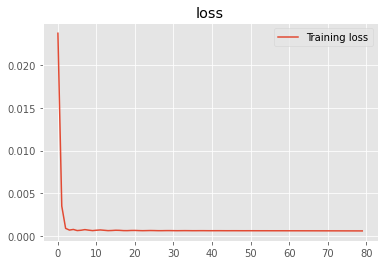

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(history, label="Training loss")
plt.legend()
plt.title('loss')
plt.show()


y_test_pred_graph (301, 1)
y_test_graph (301, 1)


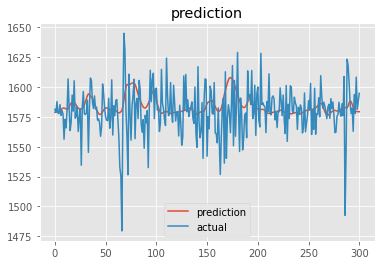

In [16]:
y_test_pred_graph = scalers[1].inverse_transform(y_test_pred.detach().numpy())
print("y_test_pred_graph", y_test_pred_graph.shape)
y_test_graph = scalers[1].inverse_transform(y_test.detach().numpy())
print("y_test_graph", y_test_graph.shape)

binary_pred = y_test_pred_graph > 0
binary_actual = y_test_graph > 0
plt.plot(y_test_pred_graph, label='prediction')
plt.plot(y_test_graph, label='actual')
plt.title("prediction")
plt.legend()
plt.show()

[1579.8422]
[1605.86672562]
y_test_pred_graph (301, 1)
y_test_graph (301, 1)


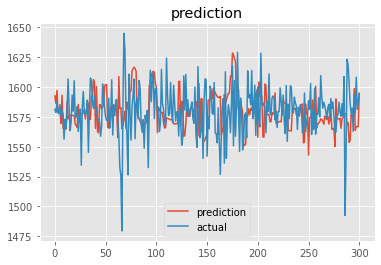

In [17]:
sentiment_gain = 150

mean_test = np.mean(scalers[1].inverse_transform(y_test.detach().numpy()), 0)
mean_pred = np.mean(scalers[1].inverse_transform(y_test_pred.detach().numpy()) + (sentiment_array * sentiment_gain), 0)
print(mean_test)
print(mean_pred)

y_test_pred_graph = scalers[1].inverse_transform(y_test_pred.detach().numpy()) + (sentiment_array * sentiment_gain) - (mean_pred - mean_test)
print("y_test_pred_graph", y_test_pred_graph.shape)
y_test_graph = scalers[1].inverse_transform(y_test.detach().numpy())
print("y_test_graph", y_test_graph.shape)

binary_pred = y_test_pred_graph > 0
binary_actual = y_test_graph > 0
plt.plot(y_test_pred_graph, label='prediction')
plt.plot(y_test_graph, label='actual')
plt.title("prediction")
plt.legend()
plt.show()

In [41]:
# ACCURACY CALCULATIONS

"""
5 classes
1) greater than -4 change
2) between -4 and -1 change
3) between -1 and 1 change
4) between 1 and 4 change
5) greater than 4 change
"""

change_dict = {"VN": -2, "N": -1, "S":0, "P":1, "VP":2}
lower = 0.015
upper = 0.025

test_change  = np.zeros((len(y_test), 1))
pred_change  = np.zeros((len(y_test), 1))
print(test_change.shape)
print(change_dict["S"])

for i in range(len(y_test)):
    temp = None
    if i == 0:
        temp = "S"
    elif y_test_graph[i] <= y_test_graph[i-1] * (1-upper):
        temp = "VN"
    elif y_test_graph[i-1] * (1-upper) < y_test_graph[i]  and y_test_graph[i] < y_test_graph[i-1] * (1-lower):
        temp = "N"
    elif y_test_graph[i-1] * (1-lower) < y_test_graph[i] and y_test_graph[i] < y_test_graph[i-1] * (1+lower):
        temp = "S"
    elif y_test_graph[i-1] * (1+lower) <= y_test_graph[i] and y_test_graph[i] <= y_test_graph[i-1] * (1+upper):
        temp = "P"
    else:
        temp = "VP"
    test_change[i] = change_dict[temp]
      


for i in range(len(y_test)):
    temp = None
    if i == 0:
        temp = "S"
    elif y_test_pred_graph[i] <= y_test_graph[i-1] * (1-upper):
        temp = "VN"
    elif y_test_graph[i-1] * (1-upper) < y_test_pred_graph[i] < y_test_graph[i-1] * (1-lower):
        temp = "N"
    elif y_test_graph[i-1] * (1-lower) <= y_test_pred_graph[i] < y_test_graph[i-1] * (1+lower):
        temp = "S"
    elif y_test_graph[i-1] * (1+lower) <= y_test_pred_graph[i] <= y_test_graph[i-1] * (1+upper):
        temp = "P"
    else:
        temp = "VP"
    
    pred_change[i] = change_dict[temp]

# print(test_change.T)
# print(pred_change.T)

# CALCULATING RIGID ACCURACY

accuracy = 0
for i in range(len(y_test)):
    if test_change[i] == pred_change[i]:
        accuracy = accuracy + 1

accuracy = accuracy / len(y_test) * 100
print("The accuracy of the classification model is {}".format(accuracy))


# CALCULATING SOFT ACCURACY (ok if it varies by 1)

soft_accuracy = 0
for i in range(len(y_test)):
    if test_change[i] == pred_change[i] - 1 or test_change[i] == pred_change[i] or test_change[i] == pred_change[i] + 1:
        soft_accuracy = soft_accuracy + 1

soft_accuracy = soft_accuracy / len(y_test) * 100
print("The soft accuracy of the classification model is {}".format(soft_accuracy))

(301, 1)
0
The accuracy of the classification model is 60.797342192691026
The soft accuracy of the classification model is 90.03322259136213
